In [1]:
! pip install pyro-ppl

In [2]:
import random
import string
import os
import itertools
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.distributions.utils import probs_to_logits
from utils import *

In [3]:
pcfg = {
  "name": "astronomers",
  "terminals": ["astronomers", "ears", "saw", "stars", "telescopes", "with"],
  "non_terminals": ["S", "NP", "VP", "PP", "P", "V"],
  "productions": {
    "S": [["NP", "VP"]],
    "NP": [["NP", "PP"], ["astronomers"], ["ears"], ["saw"], ["stars"], ["telescopes"]],
    "VP": [["V", "NP"], ["VP", "PP"]],
    "PP": [["P", "NP"]],
    "P": [["with"]],
    "V": [["saw"]]
  },
  "start_symbol": "S",
}
true_production_probs = {
    "S": [1.0],
    "NP": [0.4, 0.1, 0.18, 0.04, 0.18, 0.1],
    "VP": [0.7, 0.3],
    "PP": [1.0],
    "P": [1.0],
    "V": [1.0]
}
max_depth_parse_tree = 20
slient = True
terminate_symbol = "__"

In [4]:
prior_production_logits = {
    k: torch.randn((len(v),)) 
    for k, v in pcfg['productions'].items()
}
ground_truth_production_logits = {
    k: probs_to_logits(torch.tensor(true_production_probs[k]))
    for k, v in pcfg['productions'].items()
}
if not slient:
    print(prior_production_logits)
    print(ground_truth_production_logits)

In [5]:
def generate_sentences(production_logits):
    
    def sample_parse_tree(symbol = None, depth = 0, suffix = "root"):
        if symbol is None:
            symbol = pcfg['start_symbol']
        if symbol in pcfg['terminals']:
            return symbol
        elif depth > max_depth_parse_tree:
            return terminate_symbol
        else:
            if not slient:
                print("symbol=>", symbol, production_logits[symbol])
            distribution = dist.Categorical(logits=production_logits[symbol])
            production_index = distribution.sample().detach()
            production = pcfg['productions'][symbol][production_index]
            return [symbol] + \
                [sample_parse_tree(s, depth=depth + 1, suffix = f"{suffix}_d{depth}/{i}") for i, s in enumerate(production)]
    tree = sample_parse_tree()
    if not slient:
        print("tree =>", tree)
    sentence = get_leaves(tree, max_depth_parse_tree, terminate_symbol)
    # how do we state observations, levenshtein distance?
    # may also use factor on levenshtein distance between gen and obs sentences and observe with 0

    # pad and normal distribution but very low sigma
    gen_sentence = pad_sentence(sentence_to_one_hots(sentence, pcfg["terminals"]), len(sentence))
    return sentence, gen_sentence, tree
if not slient:
    print(generate_sentences(prior_production_logits))
    print(generate_sentences(ground_truth_production_logits))

In [6]:
import model as model
import guide_mean_field_v2 as guide

In [7]:
if not slient:
    model.model(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [8]:

obs_embedder_gru = nn.GRU(
    input_size=6,
    hidden_size=256,
    num_layers=1
)

def wrapped_guide(start_symbol='S', terminals=["astronomers", "ears", "saw", "stars", "telescopes", "with"], 
                  max_depth_parse_tree=20, terminate_symbol='__', observations={'obs': 0}):
    #print("print(observations['obs'].shape)", observations['obs'].shape)
    pyro.module('obs_embedder_gru', obs_embedder_gru)
    embedded_obs, _ = obs_embedder_gru(observations['obs'].unsqueeze(1))
    return guide.model(start_symbol, terminals, max_depth_parse_tree, terminate_symbol, {'obs' : embedded_obs[-1][0]})
if not slient:
    wrapped_guide(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [9]:
import tqdm
import matplotlib.pyplot as plt

In [10]:
pyro.clear_param_store()
smoke_test = False
n_steps = 10 if smoke_test else 20000
interval = 1 if smoke_test else 50
num_inference_samples = 2 if smoke_test else 10
optimiser = optim.Adam({"lr": 0.0005})
csis = pyro.infer.CSIS(model.model, wrapped_guide, optimiser, num_inference_samples=num_inference_samples)
avg_l = 0
loss_trace = []
steps = []

In [11]:
def print_weights(name, model):
    print("@params in", name)
    for param in model.parameters():
        print(param)
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [12]:
def draw_from_model(n=1000, ground_truth=True):
    logits = production_logits if not ground_truth else ground_truth_production_logits
    sample_sentences = [generate_sentences(logits) for _ in range(n)]
    return sample_sentences
sample_sentences = draw_from_model(n=n_steps)
if not slient:
    sample_sentences[0]

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n1 = count_parameters(guide._nn_model_sample_parse_tree_production_index_VP)
n2 = count_parameters(guide._nn_model_sample_parse_tree_production_index_NP)
n3 = count_parameters(obs_embedder_gru) # convertion_embedding
print(n1, n2, n3, "total:", n1+n2+n3)

773358 774386 202752 total: 1750496


  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_mean_field_v2.py:159: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_VP_params,
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_mean_field_v2.py:151: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_NP_params,
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [2:23:58<00:00,  2.32it/s]


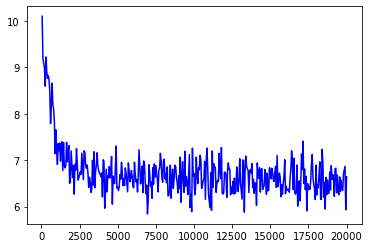

In [14]:
for step in tqdm.trange(n_steps):
    obs = sample_sentences[step]
    loss = csis.step(observations={"obs" : obs[1]})
    avg_l += loss
    if (step + 1) % interval == 0:
        steps.append(step)
        loss_trace.append(avg_l / interval)
        avg_l = 0

plt.plot(steps, loss_trace, "-b")
plt.show()

In [15]:
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [16]:
def drop_paddings(sentence_tensor):
    has_values = sentence_tensor.abs().sum(dim=-1).bool()
    return sentence_tensor[has_values]
def one_hot_sentence_to_list(sentence_tensor, terminals):
    sentence_np = sentence_tensor.cpu().detach().numpy()
    sentence_indices = np.argmax(sentence_np, axis=1)
    return [terminals[i] for i in sentence_indices]

In [17]:
def test(sentences, n=1):
    num_correct_n = 0
    num_correct_all = 0
    levenshtein_distances = {}
    for i in tqdm.trange(len(sentences)):
        obs = sentences[i]
        posterior = csis.run(observations={"obs" : obs[1]})
        marginal_ret = pyro.infer.EmpiricalMarginal(posterior)
        
        for i_sample in range(n):
            
            with torch.no_grad():
                _ret = marginal_ret()

            _ret = drop_paddings(_ret)
            num_correct_n += (torch.sum(obs[1]) == torch.sum(_ret))
            num_correct_all += torch.equal(obs[1], _ret)
            lev_dis = get_levenshtein_distance(one_hot_sentence_to_list(_ret, pcfg["terminals"]), 
                                               one_hot_sentence_to_list(obs[1], pcfg["terminals"]),
                                               pcfg["terminals"])
            if lev_dis in levenshtein_distances:
                levenshtein_distances[lev_dis] += 1
            else:
                levenshtein_distances[lev_dis] = 1
    
    avg_dis = 0  
    
    for k, v in levenshtein_distances.items():
        avg_dis += k * v

    return int(num_correct_n)  / len(sentences), int(num_correct_all) / len(sentences), levenshtein_distances, avg_dis / (len(sentences) * n)

example = ["astronomers", "saw", "stars", "with", "telescopes"]
example_sentence = sentence_to_one_hots(example, pcfg["terminals"])
print("example, n=1000", test([[None, example_sentence]], n=1000))
print("examples, 1000", test([[None, example_sentence]] * 1000))
print("train", test(sample_sentences[:1000]))
test_sentences = draw_from_model(n=1000)
print("test", test(test_sentences))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


example, n=1000 (0.0, 0.0, {2: 1000}, 2.0)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:52<00:00,  5.80it/s]


examples, 1000 (0.461, 0.059, {3: 181, 1: 295, 2: 462, 0: 59, 4: 3}, 1.774)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:46<00:00,  2.46it/s]


train (0.429, 0.257, {1: 60, 0: 257, 2: 97, 9: 33, 15: 15, 4: 63, 18: 12, 7: 41, 13: 15, 3: 88, 31: 1, 6: 53, 5: 57, 27: 5, 12: 24, 24: 7, 14: 17, 17: 11, 11: 20, 10: 23, 58: 1, 22: 8, 20: 8, 29: 1, 19: 9, 79: 2, 8: 26, 21: 2, 25: 7, 28: 1, 16: 9, 45: 1, 34: 4, 109: 1, 99: 1, 41: 3, 23: 4, 39: 1, 50: 2, 51: 1, 32: 1, 30: 2, 26: 1, 49: 1, 38: 1, 35: 2, 57: 1}, 6.565)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:59<00:00,  2.78it/s]

test (0.497, 0.295, {5: 59, 0: 295, 1: 77, 9: 28, 3: 77, 2: 104, 8: 29, 21: 8, 18: 9, 16: 15, 15: 8, 6: 40, 4: 62, 11: 28, 50: 2, 29: 3, 14: 10, 13: 13, 10: 25, 17: 11, 28: 5, 12: 15, 7: 29, 20: 4, 19: 4, 64: 1, 44: 2, 37: 3, 57: 1, 24: 3, 70: 1, 75: 1, 23: 6, 22: 1, 35: 1, 32: 3, 49: 1, 25: 2, 36: 1, 27: 3, 46: 1, 26: 1, 42: 1, 67: 1, 30: 3, 31: 1, 33: 1, 39: 1}, 5.811)


In [18]:
test_sentences = draw_from_model(n=10000)
print("test", test(test_sentences))

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [58:03<00:00,  2.87it/s]

test (0.4656, 0.2906, {2: 1025, 13: 150, 14: 125, 5: 550, 4: 659, 0: 2906, 6: 480, 9: 252, 15: 100, 3: 802, 10: 223, 45: 4, 11: 222, 20: 58, 1: 682, 26: 27, 7: 408, 8: 342, 24: 38, 16: 103, 39: 4, 55: 3, 12: 180, 43: 4, 23: 40, 54: 5, 29: 26, 34: 18, 21: 65, 17: 84, 41: 7, 40: 6, 30: 11, 28: 23, 42: 6, 18: 73, 22: 53, 33: 19, 27: 19, 19: 65, 25: 26, 31: 14, 32: 16, 35: 11, 37: 7, 44: 7, 36: 9, 64: 2, 52: 2, 49: 3, 71: 1, 61: 1, 46: 6, 65: 1, 47: 3, 51: 2, 60: 1, 58: 2, 76: 1, 79: 1, 73: 1, 89: 1, 50: 2, 48: 1, 38: 3, 53: 3, 67: 1, 56: 2, 69: 1, 59: 1, 57: 1}, 5.5593)


In [19]:
print(loss_trace)

[10.099183942675591, 9.183193861842156, 9.080586192011832, 8.990479982197284, 8.593482286334037, 9.221324554160237, 8.905623286366463, 8.763227660059929, 8.823470813371241, 8.737071865871549, 8.474186541251838, 7.7875070405751465, 8.18314527478069, 8.658659531325101, 8.200790450945497, 8.10243639389053, 7.834815368177369, 7.138937713745982, 7.65270371587947, 7.186534507004544, 6.909124374550301, 7.355087630203925, 7.204455931023695, 7.3700986300315705, 6.97990426256787, 7.257008540129755, 7.396154024351854, 6.775233067951631, 7.376946021551266, 6.888621672525769, 6.831534405085258, 6.894496429334395, 7.385290145056788, 6.964144960817648, 7.1662953824098805, 7.31464539484703, 6.501888971564476, 6.543033675523984, 7.198506787342485, 6.910761558205704, 6.623698802098516, 6.88648548962723, 6.268205247345032, 6.909889596304274, 6.783587796762877, 7.2477579885025625, 6.944075890630338, 6.569895197336737, 6.615529460479593, 6.68720647608352, 6.751204531004041, 6.697205917017709, 7.15025233453

In [20]:
print(min(loss_trace), loss_trace.index(min(loss_trace)))

5.8423924159130545 138
